In [2]:
!pip install easyocr


     |████████████████████████████████| 63.0MB 70kB/s 


In [3]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
from statistics import mode
from tensorflow import keras
from keras_preprocessing import image as op

In [4]:
# pylint: disable=invalid-name, redefined-outer-name, missing-docstring, non-parent-init-called, trailing-whitespace, line-too-long
import cv2
import numpy as np


class Label:
    def __init__(self, cl=-1, tl=np.array([0., 0.]), br=np.array([0., 0.]), prob=None):
        self.__tl = tl
        self.__br = br
        self.__cl = cl
        self.__prob = prob

    def __str__(self):
        return 'Class: %d, top left(x: %f, y: %f), bottom right(x: %f, y: %f)' % (
        self.__cl, self.__tl[0], self.__tl[1], self.__br[0], self.__br[1])

    def copy(self):
        return Label(self.__cl, self.__tl, self.__br)

    def wh(self): return self.__br - self.__tl

    def cc(self): return self.__tl + self.wh() / 2

    def tl(self): return self.__tl

    def br(self): return self.__br

    def tr(self): return np.array([self.__br[0], self.__tl[1]])

    def bl(self): return np.array([self.__tl[0], self.__br[1]])

    def cl(self): return self.__cl

    def area(self): return np.prod(self.wh())

    def prob(self): return self.__prob

    def set_class(self, cl):
        self.__cl = cl

    def set_tl(self, tl):
        self.__tl = tl

    def set_br(self, br):
        self.__br = br

    def set_wh(self, wh):
        cc = self.cc()
        self.__tl = cc - .5 * wh
        self.__br = cc + .5 * wh

    def set_prob(self, prob):
        self.__prob = prob

class DLabel(Label):
    def __init__(self, cl, pts, prob):
        self.pts = pts
        tl = np.amin(pts, axis=1)
        br = np.amax(pts, axis=1)
        Label.__init__(self, cl, tl, br, prob)

def getWH(shape):
    return np.array(shape[1::-1]).astype(float)

def IOU(tl1, br1, tl2, br2):
    wh1, wh2 = br1-tl1, br2-tl2
    assert((wh1 >= 0).all() and (wh2 >= 0).all())
    
    intersection_wh = np.maximum(np.minimum(br1, br2) - np.maximum(tl1, tl2), 0)
    intersection_area = np.prod(intersection_wh)
    area1, area2 = (np.prod(wh1), np.prod(wh2))
    union_area = area1 + area2 - intersection_area
    return intersection_area/union_area

def IOU_labels(l1, l2):
    return IOU(l1.tl(), l1.br(), l2.tl(), l2.br())

def nms(Labels, iou_threshold=0.5):
    SelectedLabels = []
    Labels.sort(key=lambda l: l.prob(), reverse=True)
    
    for label in Labels:
        non_overlap = True
        for sel_label in SelectedLabels:
            if IOU_labels(label, sel_label) > iou_threshold:
                non_overlap = False
                break

        if non_overlap:
            SelectedLabels.append(label)
    return SelectedLabels



def find_T_matrix(pts, t_pts):
    A = np.zeros((8, 9))
    for i in range(0, 4):
        xi = pts[:, i]
        xil = t_pts[:, i]
        xi = xi.T
        
        A[i*2, 3:6] = -xil[2]*xi
        A[i*2, 6:] = xil[1]*xi
        A[i*2+1, :3] = xil[2]*xi
        A[i*2+1, 6:] = -xil[0]*xi

    [U, S, V] = np.linalg.svd(A)
    H = V[-1, :].reshape((3, 3))
    return H

def getRectPts(tlx, tly, brx, bry):
    return np.matrix([[tlx, brx, brx, tlx], [tly, tly, bry, bry], [1, 1, 1, 1]], dtype=float)

def normal(pts, side, mn, MN):
    pts_MN_center_mn = pts * side
    pts_MN = pts_MN_center_mn + mn.reshape((2, 1))
    pts_prop = pts_MN / MN.reshape((2, 1))
    return pts_prop

# Reconstruction function from predict value into plate crpoped from image
def reconstruct(I, Iresized, Yr, lp_threshold):
    # 4 max-pooling layers, stride = 2
    net_stride = 2**4
    side = ((208 + 40)/2)/net_stride

    # one line and two lines license plate size
    one_line = (470, 110)
    two_lines = (280, 200)

    Probs = Yr[..., 0]
    Affines = Yr[..., 2:]

    xx, yy = np.where(Probs > lp_threshold)
    # CNN input image size 
    WH = getWH(Iresized.shape)
    # output feature map size
    MN = WH/net_stride

    vxx = vyy = 0.5 #alpha
    base = lambda vx, vy: np.matrix([[-vx, -vy, 1], [vx, -vy, 1], [vx, vy, 1], [-vx, vy, 1]]).T
    labels = []
    labels_frontal = []

    for i in range(len(xx)):
        x, y = xx[i], yy[i]
        affine = Affines[x, y]
        prob = Probs[x, y]

        mn = np.array([float(y) + 0.5, float(x) + 0.5])

        # affine transformation matrix
        A = np.reshape(affine, (2, 3))
        A[0, 0] = max(A[0, 0], 0)
        A[1, 1] = max(A[1, 1], 0)
        # identity transformation
        B = np.zeros((2, 3))
        B[0, 0] = max(A[0, 0], 0)
        B[1, 1] = max(A[1, 1], 0)

        pts = np.array(A*base(vxx, vyy))
        pts_frontal = np.array(B*base(vxx, vyy))

        pts_prop = normal(pts, side, mn, MN)
        frontal = normal(pts_frontal, side, mn, MN)

        labels.append(DLabel(0, pts_prop, prob))
        labels_frontal.append(DLabel(0, frontal, prob))
        
    final_labels = nms(labels, 0.1)
    final_labels_frontal = nms(labels_frontal, 0.1)

    #print(final_labels_frontal)
    assert final_labels_frontal, "No License plate is founded!"

    # LP size and type
    out_size, lp_type = (two_lines, 2) if ((final_labels_frontal[0].wh()[0] / final_labels_frontal[0].wh()[1]) < 1.7) else (one_line, 1)

    TLp = []
    Cor = []
    if len(final_labels):
        final_labels.sort(key=lambda x: x.prob(), reverse=True)
        for _, label in enumerate(final_labels):
            t_ptsh = getRectPts(0, 0, out_size[0], out_size[1])
            ptsh = np.concatenate((label.pts * getWH(I.shape).reshape((2, 1)), np.ones((1, 4))))
            H = find_T_matrix(ptsh, t_ptsh)
            Ilp = cv2.warpPerspective(I, H, out_size, borderValue=0)
            TLp.append(Ilp)
            Cor.append(ptsh)
    return final_labels, TLp, lp_type, Cor

def detect_lp(model, I, max_dim, lp_threshold):
    min_dim_img = min(I.shape[:2])
    factor = float(max_dim) / min_dim_img
    w, h = (np.array(I.shape[1::-1], dtype=float) * factor).astype(int).tolist()
    Iresized = cv2.resize(I, (w, h))
    T = Iresized.copy()
    T = T.reshape((1, T.shape[0], T.shape[1], T.shape[2]))
    Yr = model.predict(T)
    Yr = np.squeeze(Yr)
    #print(Yr.shape)
    L, TLp, lp_type, Cor = reconstruct(I, Iresized, Yr, lp_threshold)
    return L, TLp, lp_type, Cor


In [5]:
from keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder

In [6]:
import easyocr
import cv2
from matplotlib import pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from local_utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

In [7]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [8]:
wpod_net_path = "/content/drive/MyDrive/mosaic_PS2/wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


In [9]:
def draw_box(ind,image_path, cor, thickness=3): 
    pts=[]  
    x_coordinates=cor[ind][0]
    y_coordinates=cor[ind][1]
    # store the top-left, top-right, bottom-left, bottom-right 
    # of the plate license respectively
    for i in range(4):
        pts.append([int(x_coordinates[i]),int(y_coordinates[i])])
    
    pts = np.array(pts, np.int32)
    pts = pts.reshape((-1,1,2))
    vehicle_image = cv2.imread(image_path)
    
    cv2.polylines(vehicle_image,[pts],True,(0,255,0),thickness)
    return vehicle_image

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=350, Dmin = 350):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

In [10]:
def rotate_image(image, angle,val):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(val, val, val))
  return result
def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov
def order_points(pts):	
	rect = np.zeros((4, 2), dtype = "float32")
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	return rect
def four_point_transform(image, pts):
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	return warped

In [11]:
reader = easyocr.Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [12]:
def pred_list(img):
  img=cv2.resize(img, (256, 55))
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray,(3,3),0)
  binary = cv2.adaptiveThreshold(blur, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 
                                    11, 2)
    
  binary = cv2.bitwise_not(binary) 
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
  val=np.mean(gray)
  im_ar=img.shape[0]*img.shape[1]
  
  im=cv2.bitwise_not(thre_mor)
  contourss,_=cv2.findContours(im,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contourss:
      x, y, w, h = cv2.boundingRect(cnt)
      if cv2.contourArea(contourss[0])<cv2.contourArea(cnt) and cv2.contourArea(cnt)<0.92*im_ar and cv2.contourArea(cnt)>0.2*im_ar :
          M = cv2.moments(cnt)
          cX = int(M["m10"]/M["m00"])
          cY = int(M["m01"]/M["m00"])
          if cX>img.shape[1]*.35 and cX<img.shape[1]*.65 and cY>img.shape[0]*.35 and cY<img.shape[0]*.65:
              contourss[0]=cnt
              # print(cnt)

  rect = cv2.minAreaRect(contourss[0])

  boxx = cv2.boxPoints(rect)
  boxx = np.int0(boxx)
  im=img.copy()
  im = cv2.drawContours(im,[boxx],0,(0,0,255),2)
  x=rect[2]
  if x<-45:
    x=(90+rect[2])
  rot_image=rotate_image(img,x,val)
  rot_image=cv2.resize(rot_image, (256, 55))
  im_ar=img.shape[0]*img.shape[1]
  gray1 = cv2.cvtColor(rot_image, cv2.COLOR_BGR2GRAY)
  blur1 = cv2.GaussianBlur(gray1,(3,3),0)
  binary1 = cv2.adaptiveThreshold(blur1, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 
                                    11, 2)
    
  binary1 = cv2.bitwise_not(binary1) 
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
  thre_mor1 = cv2.morphologyEx(binary1, cv2.MORPH_DILATE, kernel3)

  im2=cv2.bitwise_not(thre_mor1)
  flag=0
  contourss,_=cv2.findContours(im2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  for cnt in contourss:
    
      # print(cv2.contourArea(cnt))
      if cv2.contourArea(contourss[0])<=cv2.contourArea(cnt) and cv2.contourArea(cnt)<0.95*im_ar and cv2.contourArea(cnt)>0.5*im_ar :
          M = cv2.moments(cnt)
          if(M["m00"]==0):
            # print('heh')
            continue
          cX = int(M["m10"]/M["m00"])
          cY = int(M["m01"]/M["m00"])
          # print(cX,cY)
          if cX>img.shape[1]*.25 and cX<img.shape[1]*.75 and cY>img.shape[0]*.35 and cY<img.shape[0]*.65:
              contourss[0]=cnt
              flag=1
  if flag==1:
    rect1 = cv2.minAreaRect(contourss[0])
    boxx1 = cv2.boxPoints(rect1)
    boxx1 = np.int0(boxx1)
    imj=rot_image.copy()
    imj = cv2.drawContours(imj,[boxx1],0,(0,0,255),2)
    # cv2_imshow(imj)
    y=min(boxx1[0][1],boxx1[1][1],boxx1[2][1],boxx1[3][1])
    y=max(y,0)
    h=max(boxx1[0][1],boxx1[1][1],boxx1[2][1],boxx1[3][1])-y
    h=min(imj.shape[0],y+h)
    x=min(boxx1[0][0],boxx1[1][0],boxx1[2][0],boxx1[3][0])
    x=max(x,0)
    w=max(boxx1[0][0],boxx1[1][0],boxx1[2][0],boxx1[3][0])-x
    w=min(imj.shape[1],x+w)
    imj=rot_image[y:y+h,x:x+w]
    imj1=cv2.resize(imj, (256, 55))
    # cv2_imshow(imj1)
  else:
    imj1=rot_image.copy()

  imaj=imj1.copy()
  imj1=cv2.resize(imj1,(256,55))
  imj4=imj1.copy()
  gray2 = cv2.cvtColor(imj4, cv2.COLOR_BGR2GRAY)
  blur2 = cv2.GaussianBlur(gray2,(3,3),0)
  binary2 = cv2.threshold(blur2, 180, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
  # binary2 = cv2.bitwise_not(binary2) 
  ## Applied dilation 
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 2))
  thre_mor2 = cv2.morphologyEx(binary2, cv2.MORPH_DILATE, kernel3)
  im_ar=imj1.shape[0]*imj1.shape[1]



  
  im=cv2.bitwise_not(thre_mor2)
  flag=0
  fg=0
  contourss,_=cv2.findContours(im,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  cntr=[]
  screenCnt = None
  for cnt in contourss:
      x, y, w, h = cv2.boundingRect(cnt)

      if cv2.contourArea(contourss[0])<=cv2.contourArea(cnt) and cv2.contourArea(cnt)<0.92*im_ar and cv2.contourArea(cnt)>0.5*im_ar :
        
          M = cv2.moments(cnt)
          if(M["m00"]==0):
            # print('heh')
            continue
          cX = int(M["m10"]/M["m00"])
          cY = int(M["m01"]/M["m00"])
          if cX>img.shape[1]*.35 and cX<imj1.shape[1]*.65 and cY>imj1.shape[0]*.35 and cY<imj1.shape[0]*.65:
            contourss[0]=cnt
            cntr.append(cnt)
            flag=1
  if flag==1:
    # print(cv2.contourArea(contourss[0])/im_ar)
    img_d=imj1.copy()
    img_d=cv2.drawContours(img_d, cntr, -1, (0, 255, 0), 2)
    # cv2_imshow(img_d)
    cnts = sorted(cntr, key=cv2.contourArea, reverse=True)[:5]
    
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            fg=1
            screenCnt = approx
            break


    imggg=imj1.copy()
    if(fg==1):
      imggg=cv2.drawContours(imggg, [screenCnt], -1, (0, 255, 0), 2)
    # cv2_imshow(imggg)
    rect1 = cv2.minAreaRect(contourss[0])
    boxx1 = cv2.boxPoints(rect1)
    boxx1 = np.int0(boxx1)
    # print(boxx1)
    rt=imaj.copy()
    rt = cv2.drawContours(rt,[boxx1],0,(0,0,255),2)
    # cv2_imshow(rt)
    y=min(boxx1[0][1],boxx1[1][1],boxx1[2][1],boxx1[3][1])
    y=max(y,0)
    h=max(boxx1[0][1],boxx1[1][1],boxx1[2][1],boxx1[3][1])-y
    h=min(imaj.shape[0],y+h)
    x=min(boxx1[0][0],boxx1[1][0],boxx1[2][0],boxx1[3][0])
    x=max(x,0)
    w=max(boxx1[0][0],boxx1[1][0],boxx1[2][0],boxx1[3][0])-x
    w=min(imaj.shape[1],x+w)
    imjj=imaj[y:y+h,x:x+w]
    
  else:
    imjj=imaj.copy()



  if (fg==1):
    pts = np.array(screenCnt.reshape(4, 2))
    imjj = four_point_transform(imj1, pts)
  imjj=cv2.resize(imjj,(256,55))
  imjj1=shadow_remove(imjj)
  gray3 = cv2.cvtColor(imjj1, cv2.COLOR_BGR2GRAY)
  blur3 = cv2.GaussianBlur(gray3,(3,3),0)
  binary3 = cv2.threshold(blur3, 180, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  # thre_mor3 = cv2.morphologyEx(binary3, cv2.MORPH_DILATE, kernel3)
  thre_mor3 = cv2.morphologyEx(binary3, cv2.MORPH_ERODE, (3,3))


  gray3 = cv2.cvtColor(imjj, cv2.COLOR_BGR2GRAY)
  blur3 = cv2.GaussianBlur(gray3,(5,5),0)
  binary4 = cv2.adaptiveThreshold(blur3, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY, 
                                    11, 2)
    
  binary4 = cv2.bitwise_not(binary4)  
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  thre_mor34 = cv2.morphologyEx(binary4, cv2.MORPH_DILATE, kernel3)
  thre_mor34 = cv2.morphologyEx(thre_mor34, cv2.MORPH_ERODE, (3,3))
  thre_mor3= cv2.rectangle(thre_mor3,(0,0),( binary3.shape[1], binary3.shape[0] ),(0,0,0),4)
  thre_mor34= cv2.rectangle(thre_mor34,(0,0),( binary3.shape[1], binary3.shape[0] ),(0,0,0),4)
  imjjj=imjj.copy()





  ctrs, _ = cv2.findContours(thre_mor3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
  img_area = imjj.shape[0]*imjj.shape[1]
  width=[]
  height=[]
  Mcy=[]
  for i, ctr in enumerate(sorted_ctrs):
      x, y, w, h = cv2.boundingRect(ctr)
    
      roi_area = w*h
      roi_ratio = roi_area/img_area
      # print(roi_ratio)
      M = cv2.moments(ctr)
      if(M["m00"]==0):
        # print('heh')
        continue
      cX = int(M["m10"]/M["m00"])
      cY = int(M["m01"]/M["m00"])
      # if cY>imjjj.shape[0]*.35 and cY<imjjj.shape[0]*.65:
        # print('ratio', roi_ratio)
          
      if roi_ratio>0.01 and roi_ratio<0.25 and h<2*w and w<imjjj.shape[1]/8:
          # print('w',w)
          width.append(w)
          Mcy.append(cY)
      if roi_ratio>0.01 and roi_ratio<0.25 and h>=0.8*w and h<imjjj.shape[0]*0.9:
          # print('h',h)
          height.append(h)
  if (len(width)==0):
    mw=22
  else:
    mw=sum(width)/len(width)

  if (len(height)==0):
    mh=35
  else:
    mh=sum(height)/len(height)

  if (len(Mcy)==0):
    mcy=27
  else:
    mcy=sum(Mcy)/len(Mcy)



  # print('mw is',mw)
  # print('mh is',mh)
  rd=[]
  for i, ctr in enumerate(sorted_ctrs):
      x, y, w, h = cv2.boundingRect(ctr)
    
      roi_area = w*h
      roi_ratio = roi_area/img_area
      # print(roi_ratio)
      M = cv2.moments(ctr)
      if(M["m00"]==0):
        # print('heh')
        continue
      cX = int(M["m10"]/M["m00"])
      cY = int(M["m01"]/M["m00"])
      if roi_ratio>0.01 and roi_ratio<0.25 and cY<mcy+10 and cY>mcy-10:
          # print('x',x,y,w,h)
          flag=0    
          if (5*w>=h) and w<5*h and h<imjjj.shape[0]*0.9:
            
            if (w>1.4*mw and h<1.3*mh and h>0.8*mh ):
                # print('wait')
                k=h/w
                if (k<1.3 and k>0.75):
                  k=k
                else:
                  # print(x,w)
                  # print(k)
                  cv2.rectangle(imjjj,(x,y),( x + int(w/2), y + h ),(90,0,255),2)
                  cv2.rectangle(imjjj,(x+int(w/2),y),( x + w, y + h ),(90,0,255),2)
                  rd.append([x,y,int(w/2),h])
                  rd.append([int(x+w/2),y,int(w/2),h])
                  flag=1 
            if (flag==0 and h<1.3*mh and h>0.7*mh): 
                # print('XXX',x,y,w,h)
                rect2 = cv2.minAreaRect(ctr)
                cv2.rectangle(imjjj,(x,y),( x + w, y + h ),(90,0,255),2)
                rd.append([x,y,w,h])
  rd.sort() 







  imjjj1=imjj.copy()
  ctrs, _ = cv2.findContours(thre_mor34, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
  img_area = imjj.shape[0]*imjj.shape[1]
  width=[]
  height=[]
  Mcy=[]
  for i, ctr in enumerate(sorted_ctrs):
      x, y, w, h = cv2.boundingRect(ctr)
    
      roi_area = w*h
      roi_ratio = roi_area/img_area
      # print(roi_ratio)
      M = cv2.moments(ctr)
      if(M["m00"]==0):
        # print('heh')
        continue
      cX = int(M["m10"]/M["m00"])
      cY = int(M["m01"]/M["m00"])
      # if cY>imjjj.shape[0]*.35 and cY<imjjj.shape[0]*.65:
        # print('ratio', roi_ratio)
          
      if roi_ratio>0.01 and roi_ratio<0.25 and h<2*w and w<imjjj1.shape[1]/8:
          # print('w',w)
          width.append(w)
          Mcy.append(cY)
      if roi_ratio>0.01 and roi_ratio<0.25 and h>=0.8*w and h<imjjj1.shape[0]*0.9:
          # print('h',h)
          height.append(h)
  if (len(width)==0):
    mw=22
  else:
    mw=sum(width)/len(width)

  if (len(height)==0):
    mh=35
  else:
    mh=sum(height)/len(height)

  if (len(Mcy)==0):
    mcy=27
  else:
    mcy=sum(Mcy)/len(Mcy)



  # print('mw is',mw)
  # print('mh is',mh)
  rd1=[]
  for i, ctr in enumerate(sorted_ctrs):
      x, y, w, h = cv2.boundingRect(ctr)
    
      roi_area = w*h
      roi_ratio = roi_area/img_area
      # print(roi_ratio)
      M = cv2.moments(ctr)
      if(M["m00"]==0):
        # print('heh')
        continue
      cX = int(M["m10"]/M["m00"])
      cY = int(M["m01"]/M["m00"])
      if roi_ratio>0.01 and roi_ratio<0.25 and cY<mcy+10 and cY>mcy-10:
          # print('x',x,y,w,h)
          flag=0    
          if (5*w>=h) and w<5*h and h<imjjj1.shape[0]*0.9:
            
            if (w>1.4*mw and h<1.3*mh and h>0.8*mh ):
                # print('wait')
                k=h/w
                if (k<1.3 and k>0.75):
                  k=k
                else:
                  # print(x,w)
                  # print(k)
                  cv2.rectangle(imjjj1,(x,y),( x + int(w/2), y + h ),(90,0,255),2)
                  cv2.rectangle(imjjj1,(x+int(w/2),y),( x + w, y + h ),(90,0,255),2)
                  rd1.append([x,y,int(w/2),h])
                  rd1.append([int(x+w/2),y,int(w/2),h])
                  flag=1 
            if (flag==0 and h<1.3*mh and h>0.7*mh): 
                # print('XXX',x,y,w,h)
                rect2 = cv2.minAreaRect(ctr)
                cv2.rectangle(imjjj1,(x,y),( x + w, y + h ),(90,0,255),2)
                rd1.append([x,y,w,h])
  rd1.sort() 





  lis=[]
  for x,y,w,h in rd:
    
    lis.append(cv2.copyMakeBorder(binary3[y:y+h,x:x+w],10,10,10,10,0))


  kl=len(lis)
  for i in range(kl):
    k=cv2.resize(lis[i],(lis[i].shape[1]*3,lis[i].shape[0]*3))
    
    lis[i]=k

  liss=[]
  for x,y,w,h in rd1:
    
    liss.append(cv2.copyMakeBorder(binary4[y:y+h,x:x+w],10,10,10,10,0))


  kls=len(liss)
  for i in range(kls):
    k=cv2.resize(liss[i],(liss[i].shape[1]*3,liss[i].shape[0]*3))
    
    liss[i]=k
  

  l1=len(lis)
  l2=len(liss)

  if (l1<=8):
    flist=liss.copy()
  elif l1==l2:
    flist=liss.copy()
  else:
    flist=lis.copy()

  kl=len(flist)

  mape=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

  listt=[]
  for i in range(45):
    listt.append(i+1)
  cv2.imwrite('xyz.png',imjj)
  img12=cv2.imread('/content/xyz.png')
  
  result = reader.readtext('xyz.png', contrast_ths=0.05, adjust_contrast=0.7, add_margin=0.45 , width_ths=0.7 , decoder='beamsearch' , rotation_info=listt )
  easy=[]
  for i in range(len(result)):
    for j in range(len(result[i][1])):
      if result[i][1][j] in mape:
        easy.append(result[i][1][j])
  k3=len(easy)
  mapey=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
  for i in range(k3):
    if easy[i] in mapey:
      if easy[i].islower():
        easy[i] = easy[i].swapcase()

  modelc = keras.models.load_model('/content/drive/MyDrive/mosaic_PS2/modelchar1.h5')
  modeln = keras.models.load_model('/content/drive/MyDrive/mosaic_PS2/modelnum2.h5')
  model1 = keras.models.load_model('/content/drive/MyDrive/mosaic_PS2/mosaic2 (1).h5')
  mapn=['0','1','2','3','4','5','6','7','8','9']
  map=['0','1','2','3','4','5','6','7','8','9','A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
  mapc=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
  y_pred=[]
  for i in range(kl):
    cv2.imwrite('xyz.png',flist[i])
    img12=cv2.imread('/content/xyz.png')
    img12=cv2.resize(img12,(80,80))
    x = op.img_to_array(img12) 
    x = np.expand_dims(x, axis=0)
    #x = x/255.0
    img12=x
    ans=model1.predict(img12) 
    # print(ans)
    f=ans.argmax(axis=-1)
    y_pred.append(int(f))

  t=[]
  for i in y_pred:
    t.append(map[int(i)])




  y_pred=[]

  if kl==10:
    for i in range(kl):
      cv2.imwrite('xyz.png',flist[9-i])
      img12=cv2.imread('/content/xyz.png')
      img12=cv2.resize(img12,(80,80))
      x = op.img_to_array(img12) 
      x = np.expand_dims(x, axis=0)
      #x = x/255.0
      img12=x
      if (i==0 or i==1 or i==2 or i==3 or i==6 or i==7):
        ans=modeln.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(mapn[int(f)])
      elif (i==4 or i==5 or i==8 or i==9):
        ans=modelc.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(mapc[int(f)])
    y_pred.reverse()
  elif kl==9:
    for i in range(kl):
      cv2.imwrite('xyz.png',flist[8-i])
      img12=cv2.imread('/content/xyz.png')
      img12=cv2.resize(img12,(80,80))
      x = op.img_to_array(img12) 
      x = np.expand_dims(x, axis=0)
      #x = x/255.0
      img12=x
      if (i==0 or i==1 or i==2 or i==3 or i==6):
        ans=modeln.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(mapn[int(f)])
      elif i==5:
        ans=model1.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(map[int(f)])

      elif (i==4 or i==7 or i==8):
        ans=modelc.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(mapc[int(f)])
    y_pred.reverse()
  elif kl==11:
    for i in range(kl-1):
      cv2.imwrite('xyz.png',flist[10-i])
      img12=cv2.imread('/content/xyz.png')
      img12=cv2.resize(img12,(80,80))
      x = op.img_to_array(img12) 
      x = np.expand_dims(x, axis=0)
      #x = x/255.0
      img12=x
      if (i==0 or i==1 or i==2 or i==3 or i==6 or i==7):
        ans=modeln.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(mapn[int(f)])
      elif (i==4 or i==5 or i==8):
        ans=modelc.predict(img12)  
        f=ans.argmax(axis=-1)
        y_pred.append(mapc[int(f)])
    if y_pred[8]=='B':
      y_pred.append('W')
    else:
      y_pred.append('M') 
    y_pred.reverse()
  else:
    cv2.imwrite('xyz.png',imjj)
    img12=cv2.imread('/content/xyz.png')
    
    result = reader.readtext('xyz.png', contrast_ths=0.05, adjust_contrast=0.7, add_margin=0.45 , width_ths=0.7 , decoder='beamsearch' , rotation_info=listt )

    for i in range(len(result)):
      for j in range(len(result[i][1])):
        if result[i][1][j] in mape:
          y_pred.append(result[i][1][j])
  kl=len(y_pred)
  if (kl>=6):
    if y_pred[0]=='M':
      if y_pred[1]!='P' and y_pred[1]!='H' and y_pred[1]!='N' and y_pred[1]!='L' and y_pred[1]!='Z':
        if y_pred[1]=='E':
          y_pred[1]='L'
        else:
            y_pred[1]='H'
    if y_pred[1]=='X':
      y_pred[1]='K'
        
    if y_pred[0]=='X' and (y_pred[1]=='L' or y_pred[1]=='A'):
      y_pred[0]='K'
    if y_pred[1]=='B' and (y_pred[0]=='N' or y_pred[0]=='H'):
      y_pred[0]='W'
    if y_pred[0]=='D' and (y_pred[0]=='D' or y_pred[0]=='N'):
      y_pred[1]='L'
    
  k1=len(y_pred)
  k2=len(t)
  k3=len(easy)  

  if (k3>=6):
    if easy[0]=='M':
      if easy[1]!='P' and easy[1]!='H' and easy[1]!='N' and easy[1]!='L' and easy[1]!='Z':
        if easy[1]=='E':
          easy[1]='L'
        else:
          easy[1]='H'
    if easy[1]=='X':
      easy[1]='K'
        
    if easy[0]=='X' and (easy[1]=='L' or easy[1]=='A'):
      easy[0]='K'
    if easy[1]=='B' and (easy[0]=='N' or easy[0]=='H'):
      easy[0]='W'

    



  fpred=[]
  if k2==k3 and k2>=8:
    if k1==10:

      for i in range(10):
        if (i==0 or i==1 or i==4 or i==5):
          klist=[]
          klist.append(y_pred[i])
          if easy[i] in mapc:
            klist.append(easy[i])
          if t[i] in mapc:
            klist.append(t[i])
          w=len(klist)
          if w==2 and klist[0]!=klist[1]:
            
            fpred.append(easy[i])
          elif w==3 and klist[0]!=klist[1] and klist[1]!=klist[2] and klist[2]!=klist[0]:
    
            fpred.append(easy[i])
          else:
            fpred.append(mode(klist))
        if (i==2 or i==3 or i==6 or i==7 or i==8 or i==9):
          klist=[]
          klist.append(y_pred[i])
          if easy[i] in mapn:
            klist.append(easy[i])
          if t[i] in mapn:
            klist.append(t[i])
          w=len(klist)
          
          if w==2 and klist[0]!=klist[1]:

            fpred.append(easy[i])
          elif w==3 and klist[0]!=klist[1] and klist[1]!=klist[2] and klist[2]!=klist[0]:
            fpred.append(easy[i])
          
          else:
            
            fpred.append(mode(klist))
            # print(i, len(fpred))
      
    elif k1==9:
      for i in range(9):
        if (i==0 or i==1 or i==4 ):
          klist=[]
          klist.append(y_pred[i])
          if easy[i] in mapc:
            klist.append(easy[i])
          if t[i] in mapc:
            klist.append(t[i])
          w=len(klist)
          if w==2 and klist[0]!=klist[1]:
            fpred.append(easy[i])
          elif w==3 and klist[0]!=klist[1] and klist[1]!=klist[2] and klist[2]!=klist[0]:
            fpred.append(easy[i])
          else:
            fpred.append(mode(klist))
        if (i==2  or i==6 or i==7 or i==8 or i==5):
          klist=[]
          klist.append(y_pred[i])
          if easy[i] in mapn:
            klist.append(easy[i])
          if t[i] in mapn:
            klist.append(t[i])
          w=len(klist)
          if w==2 and klist[0]!=klist[1]:
            fpred.append(easy[i])
          elif w==3 and  klist[0]!=klist[1] and klist[1]!=klist[2] and klist[2]!=klist[0]:
            fpred.append(easy[i])
          else:
            fpred.append(mode(klist))
        if (i==3):
          klist=[]
          klist.append(y_pred[i])
          klist.append(t[i])
          klist.append(easy[i])
          if klist[0]!=klist[1] and klist[1]!=klist[2] and klist[2]!=klist[0]:
            fpred.append(easy[i])
          else:
            fpred.append(mode(klist))       
    else:
      fpred=easy.copy()   
   
          
  elif k1<8:
    fpred=easy.copy()
  else:
    fpred=y_pred.copy() 
  if (len(fpred)==0):
    fpred=easy.copy()
  if (len(fpred)==0):
    return fpred,flist
  if (fpred[0]=="B"):
    if (fpred[1]=="L"):
      fpred[0]="D"
  if (fpred[0]=="H"):
    if (fpred[1]=="K"):
      fpred[1]="R"
  if (fpred[0]=="N"):
    if (fpred[1]=="H"):
      fpred[0]="M"
  if (fpred[0]=="K"):
    if (fpred[1]=="E"):
      fpred[1]="L"
  if (fpred[0]=="I"):
    if (fpred[1]=="N"):
      fpred[0]="T"
  return fpred, flist

      







In [20]:


test_image_path = "Cars311.png"
vehicle, LpImg,cor = get_plate(test_image_path)

imgs1=[]
ftrings=[]
for i in range(len(LpImg)):
  img_k=draw_box(i,test_image_path, cor, thickness=3)
  ing=LpImg[i]
  ing = np.uint8(255 * ing)
  ing=cv2.cvtColor(ing, cv2.COLOR_RGB2BGR)
  pred_l,flist=pred_list(ing)
  
  strng=""
  for i in pred_l:
    strng+=i
  img_k = cv2.putText(img_k,strng , (50,50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255, 0, 0), 2, cv2.LINE_AA)
  if len(strng)>3:
    ftrings.append(flist)
    imgs1.append(img_k)





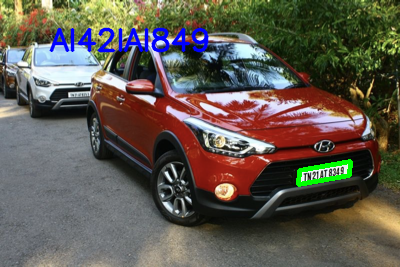

In [21]:
for i in imgs1:
  cv2_imshow(i)

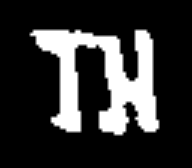

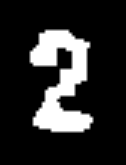

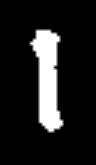

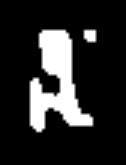

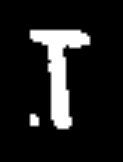

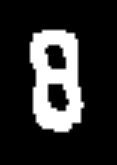

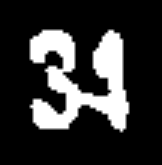

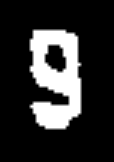

++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++


In [22]:
for i in range(len(ftrings)):
  for k in ftrings[i]:
    cv2_imshow(k)
  print("++++++++++++++++++++++++++++++++++++++++++++")
  print("++++++++++++++++++++++++++++++++++++++++++++")